# Astronomical Coordinates 2: Transforming Coordinate Systems and Representations

## Authors
Adrian Price-Whelan, Saima Siddiqui, Zihao Chen, Luthien Liu

## Learning Goals
* Introduce key concepts in `astropy.coordinates`: coordinate component formats, representations, and frames
* Demonstrate how to work with coordinate representations, for example, to change from Cartesian to Cylindrical coordinates
* Introduce coordinate frame transformations and demonstrate transforming from ICRS coordinates to Galactic and Altitude-Azimuth coordinates

## Keywords
coordinates, OOP


## Summary

In the previous tutorial in this series, we showed how astronomical coordinates in the ICRS or equatorial coordinate system can be represented in Python using the `SkyCoord` object ([docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)). There are many other coordinate systems that are commonly used in astronomical research. For example, the Galactic coordinate system is often used in radio astronomy and Galactic science, the "horizontal" or altitude-azimuth frame is often used for observatory-specific observation planning, and Ecliptic coordinates are often used for solar system science or space mission footprints. All of these coordinate frames (and others!) are supported by `astropy.coordinates`. As we will see below, the `SkyCoord` object is designed to make transforming between these systems a straightforward task.

In this tutorial, we will explore how the `astropy.coordinates` package can be used to transform astronomical coordinates between different coordinate systems or frames. You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link. 

*Note: This is the 2nd tutorial in a series of tutorials about astropy.coordinates. If you are new to astropy.coordinates, you may want to start from the beginning or an earlier tutorial.*
- [Previous tutorial: Astronomical Coordinates 1 - Getting Started](1-Coordinates-Intro)
- [Next tutorial: Astronomical Coordinates 3 - Working with Velocity Data](3-Coordinates-Velocities)

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
matplotlib
numpy



## Imports

We start by importing some general packages that we will need below:

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file

## Key `astropy.coordinates` Concepts: Component Formats, Representations, and Frames

Usage of the term "coordinates" is overloaded in astronomy and is often used interchangeably when referring to data formats (e.g., sexagesimal vs. decimal), representations (e.g., Cartesian vs. spherical), and frames (e.g., equatorial vs. galactic). In `astropy.coordinates`, we have tried to formalize these three concepts and have made them a core part of the way we interact with objects in this subpackage ([docs](https://docs.astropy.org/en/stable/coordinates/index.html#overview-of-astropy-coordinates-concepts)). Here we will give an overview of these different concepts as we build up to demonstrating how to transform between different astronomical reference frames or systems.


## Coordinate Component Formats

In our previous tutorial, we showed that it is possible to pass in coordinate component data to the `SkyCoord` initializer as strings or as `Quantity` objects in a variety of formats and units. We also saw that the coordinate components of `SkyCoord` objects can be re-formatted. For example, we can change the coordinate *format* by changing the component units, or converting the data to a string:

In [3]:
c = SkyCoord(ra=15.9932*u.deg, dec=-10.52351344*u.deg)
print(c.ra.hourangle)
print(c.to_string('hmsdms'))
print(c.dec.to_string(sep=':', precision=5))

1.0662133333333335
01h03m58.368s -10d31m24.648384s
-10:31:24.64838


See the previous tutorial [Astronomical Coordinates 1 - Getting Started](1-Coordinates-Intro) for more examples of this.

## Coordinate Representations

In the previous tutorial, we only worked with coordinate data in spherical representations (longitude/latitude), but `astropy.coordinates` also supports other coordinate representations like Cartesian, cylindrical, etc. ([docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html#astropy-skycoord-representations)). To retrieve the coordinate data in a different representation, we can use the `SkyCoord.represent_as()` method. This method either takes a string name of the desired representation, for example:

In [4]:
c.represent_as('cartesian')

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.94512547, 0.27088898, -0.18263903)>

or it accepts an `astropy.coordinates` `Representation` class, such as:

In [5]:
c.represent_as(coord.CartesianRepresentation)

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.94512547, 0.27088898, -0.18263903)>

A list of all supported representations is given in the documentation ([docs](https://docs.astropy.org/en/stable/coordinates/representations.html#astropy-coordinates-representations)), or can be identified as class names that end in `Representaton`:

In [6]:
print([x for x in dir(coord) 
       if x.endswith('Representation') and not x.startswith('Base')])

['CartesianRepresentation', 'CylindricalRepresentation', 'GRS80GeodeticRepresentation', 'PhysicsSphericalRepresentation', 'RadialRepresentation', 'SphericalRepresentation', 'UnitSphericalRepresentation', 'WGS72GeodeticRepresentation', 'WGS84GeodeticRepresentation']


In the `SkyCoord` object that we defined above, we only specified sky positions (i.e., no distance data), so the units of the Cartesian components that are returned above are dimensionless and are interpreted as being on the surface of the (dimensionless) unit sphere. If we instead pass in a distance to `SkyCoord` using the `distance` keyword argument, we instead get a `CartesianRepresentation` object for the 3D position with positional units. For example:

In [7]:
c2 = SkyCoord(ra=15.9932 * u.deg, 
              dec=-10.52351344 * u.deg,
              distance=127.4 * u.pc)

In [8]:
c2.represent_as('cartesian')

<CartesianRepresentation (x, y, z) in pc
    (120.40898448, 34.5112558, -23.2682118)>

Or, we could represent this data with cylindrical components:

In [9]:
c2.represent_as('cylindrical')

<CylindricalRepresentation (rho, phi, z) in (pc, rad, pc)
    (125.2571368, 0.279134, -23.2682118)>

To summarize, using `SkyCoord.represent_as()` is a convenient way to retrieve your coordinate data in a different representation, like Cartesian or Cylindrical. You can also change (in place) the representation of a `SkyCoord` object by setting the `SkyCoord.representation_type` attribute. For example, if we create a `SkyCoord` again with a distance, the default representation type is spherical:

In [10]:
c3 = SkyCoord(ra=15.9932 * u.deg, 
              dec=-10.52351344 * u.deg,
              distance=127.4 * u.pc)
print(c3.representation_type)
c3

<class 'astropy.coordinates.representation.spherical.SphericalRepresentation'>


<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (15.9932, -10.52351344, 127.4)>

We can, however, change the internal representation of the data by setting the `representation_type` attribute to a new `Representation` class:

In [11]:
c3.representation_type = coord.CylindricalRepresentation

This then changes the way `SkyCoord` will display the components:

In [12]:
c3

<SkyCoord (ICRS): (rho, phi, z) in (pc, deg, pc)
    (125.2571368, 15.9932, -23.2682118)>

Note, however, that changing the representation will also change the components that are available on a given `SkyCoord` object: Once we set the `representation_type` to cylindrical, the attributes `.ra` and `.dec` will no longer work, and we instead have to use the cylindrical component names to access the data. In this case, these are `.rho` for radius, `.phi` for azimuth, `.z` for $z$ position:

In [13]:
c3.rho, c3.phi, c3.z

(<Quantity 125.2571368 pc>, <Angle 15.9932 deg>, <Quantity -23.2682118 pc>)

## Transforming Between Coordinate Frames

The third key concept to keep in mind when thinking about astronomical coordinate data is the reference frame or coordinate system that the data are in. In the previous tutorial, and so far here, we have worked with the default frame assumed by `SkyCoord`: the International Celestial Reference System (ICRS; [some important definitions and context about the ICRS is given here](https://arxiv.org/abs/astro-ph/0602086)). The ICRS is the fundamental coordinate system used in most modern astronomical contexts and is generally what people mean when they refer to "equatorial" or "J2000" or "RA/Dec" coordinates (but there are some important caveats if you are working with older data). As noted above, however, there are many other coordinate systems used in different astronomical, solar, or solar system contexts. 

Some other common coordinate systems are defined as a rotation away from the ICRS that is defined to make science applications easier to interpret. One example here is the Galactic coordinate system, which is rotated with respect to the ICRS to approximately align the Galactic plane with latitude=0. As an example of the `astropy.coordinates` frame transformation machinery, we will load in a subset of a catalog of positions and distances to a set of open clusters in the Milky Way from Cantat-Gaudin et al. 2018 ([Table 1 in this catalog](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/618/A93/table1)). We have pre-selected the 474 clusters within 2 kpc of the sun and provide the catalog as a data file next to this notebook. This catalog provides sky position (columns `RAJ2000` and `DEJ2000` in the original catalog) and distance estimates (column `dmode` in the original catalog), which we have renamed in the table we provide to column names `'ra'`, `'dec'`, and `'distance'`. We will start by loading the catalog as a `QTable`  using `astropy.table` ([docs](https://docs.astropy.org/en/stable/table/)):

In [14]:
tbl = QTable.read('Cantat-Gaudin-open-clusters.ecsv')

We can now pass the coordinate components to `SkyCoord` to create a single array-valued `SkyCoord` object to represent the positions of all of the open clusters in this catalog. Note that below we will explicitly specify the coordinate frame using `frame='icrs'`: Even though this is the default frame, it is often better to be explicit so that it is clearer to someone reading the code what the coordinate system is:

In [15]:
open_cluster_c = SkyCoord(
    ra=tbl['ra'],
    dec=tbl['dec'],
    distance=tbl['distance'],
    frame='icrs')
len(open_cluster_c)

474

To see the first few coordinate entries, we can "slice" the array-valued coordinate object like we would a Python list or numpy array:

In [16]:
open_cluster_c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [( 51.87 , 34.981,  629.6), (288.399, 36.369,  382.2),
     (295.548, 27.366,  522.9), (298.306, 39.349, 1034.6)]>

Let's now visualize the sky positions of all of these clusters, colored by their distances. To plot these in an all-sky spherical projection (e.g., aitoff) using `matplotlib`, with longitude increasing to the left as is typically done for plotting astronomical objects on the sky, we have to trick `matplotlib` a little bit: We have to pass in the *negative* angle values when plotting, then reformat the tick labels to make them positive values again. We have written a short function below to handle this trick:

In [17]:
def coordinates_aitoff_plot(coords):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))
    
    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian,
                    c=sph.distance.value)

    def fmt_func(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    ticker = mpl.ticker.FuncFormatter(fmt_func)
    ax.xaxis.set_major_formatter(ticker)

    ax.grid()
    
    cb = fig.colorbar(cs)
    cb.set_label('distance [pc]')
    
    return fig, ax

Now we can plot the sky positions by passing our `SkyCoord` object in to this `coordinates_aitoff_plot()` plot helper function:

Text(0, 0.5, 'Dec [deg]')

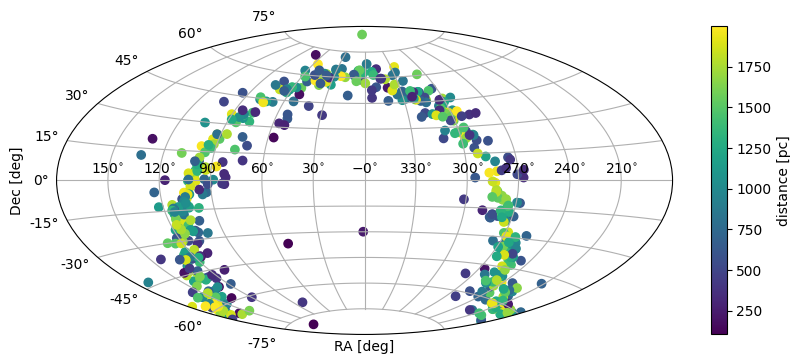

In [18]:
fig, ax = coordinates_aitoff_plot(open_cluster_c)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

The majority of these open clusters are relatively close to the Galactic midplane, which is why they form a fairly narrow "band" on the sky in ICRS coordinates. If we transform these positions to Galactic coordinates, we would therefore expect the points to appear around the latitude $b=0$ line. 

To transform our coordinates from ICRS to Galactic (or any other coordinate system), we can use the `SkyCoord.transform_to()` method and pass in the new coordinate frame instance (in this case, `Galactic()`):

In [19]:
open_cluster_gal = open_cluster_c.transform_to(Galactic())

While the recommended way of transforming `SkyCoord` objects to new frames is by passing in a frame class *instance* as we demonstrated in the cell above, `SkyCoord` also supports a shorthand for transforming some frames by accessing attributes (named as the lower-case version of the new frame name):

In [20]:
open_cluster_gal = open_cluster_c.galactic

The transformed `SkyCoord` object now contains coordinate data in the `Galactic` coordinate frame:

In [21]:
open_cluster_gal[:4]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(155.72353157, -17.76999215,  629.59997559),
     ( 68.02807936,  11.60790067,  382.20001221),
     ( 62.82445527,   2.06275608,  522.90002441),
     ( 74.37841053,   6.07393592, 1034.59997559)]>

Comparing this to the original `SkyCoord`, note that the names of the longitude and latitude components have changed from `ra` to `l` and from `dec` to `b`, per convention. We can therefore access the new Galactic longitude/latitude data using these new attribute names:

In [22]:
open_cluster_gal.l[:3]

<Longitude [155.72353157,  68.02807936,  62.82445527] deg>

In [23]:
open_cluster_gal.b[:3]

<Latitude [-17.76999215,  11.60790067,   2.06275608] deg>

*Note: the ICRS coordinate component names (`.ra`, `.dec`) will therefore **not** work on this new, transformed `SkyCoord` instance, `open_cluster_gal`*

With this new `SkyCoord` object (in the Galactic frame), let's re-make a sky plot to visualize the sky positions of the open clusters in Galactic coordinates:

Text(0, 0.5, 'Galactic latitude, $b$ [deg]')

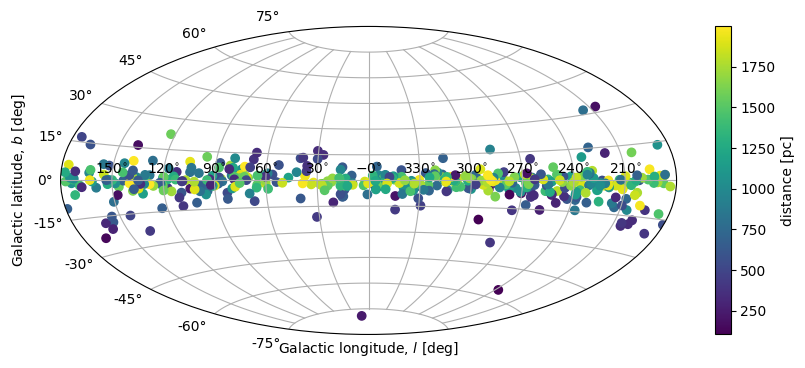

In [24]:
fig, ax = coordinates_aitoff_plot(open_cluster_gal);
ax.set_xlabel('Galactic longitude, $l$ [deg]')
ax.set_ylabel('Galactic latitude, $b$ [deg]')

As we hoped and expected, in the Galactic coordinate frame, the open clusters predominantly appear at low galactic latitudes!

## Transforming to More Complex Coordinate Frames: Computing the Altitude of a Target at an Observatory

To determine whether a target is observable from a given observatory on Earth or to find out what targets are observable from a city or place on Earth at some time, we sometimes need to convert a coordinate or set of coordinates to a frame that is local to an on-earth observer. The most common choice for such a frame is "horizontal" or "Altitude-Azimuth" coordinates. In this frame, the sky coordinates of a source can be specified as an altitude from the horizon and an azimuth angle at a specified time. This coordinate frame is supported in `astropy.coordinates` through the `AltAz` coordinate frame.

The `AltAz` frame is different from the previously-demonstrated `Galactic` frame in that it requires additional metadata to define the frame instance. Since the `Galactic` frame is close to being a 3D rotation away from the ICRS frame, and that rotation matrix is fixed, we could transform to `Galactic` by instantiating the class with no arguments (see the example above where we used `.transform_to(Galactic())`). In order to specify an instance of the `AltAz` frame, we have to (at minimum) pass in (1) a location on Earth, and (2) the time (or times) we are requesting the frame at. 

In `astropy.coordinates`, we specify locations on Earth with the `EarthLocation` class ([docs](https://docs.astropy.org/en/stable/api/astropy.coordinates.EarthLocation.html)). If we know the Earth longitude and latitude of our site, we can use these to create an instance of `EarthLocation` directly:

In [25]:
demo_loc = EarthLocation.from_geodetic(
    lon=-74.32834*u.deg, lat=43.05885*u.deg)

The `EarthLocation` class also provides handy short-hands for retrieving an instance for a given street address (by querying the [OpenStreetMap](https://www.openstreetmap.org/) web API):

In [26]:
demo_loc = EarthLocation.of_address('162 Fifth Ave, New York, NY 10010')

Or for an astronomical observatory (use `EarthLocation.get_site_names()` to see a list of all available sites). For example, to retrieve an `EarthLocation` instance for the position of Kitt Peak National Observatory (in AZ, USA):

In [27]:
observing_location = EarthLocation.of_site('Kitt Peak')

We will use Kitt Peak as our site.

As an example, we will now compute the altitude of a few of the open clusters from our catalog above over the course of a night. We have an object to represent our location on Earth, so now we need to create a set of times to compute the `AltAz` frame for. `AltAz` expects time information to be passed in as an `astropy.time.Time` object ([docs](https://docs.astropy.org/en/stable/api/astropy.time.Time.html); which can contain an array of times). Let's pretend we have an observing run coming up on Dec 18, 2020, and we would like to compute the altitude/azimuth coordinates for our open clusters over that whole night.

In [28]:
# 1AM UTC = 6PM local time (AZ mountain time), roughly the start of a night
observing_date = Time('2020-12-18 1:00')

# Compute the alt/az over a 14 hour period, starting at 6PM local time,
# with 256 equally spaced time points:
time_grid = observing_date + np.linspace(0, 14, 256) * u.hour

Now we use our location, `observing_location`, and this grid of times, `time_grid`, to create an `AltAz` frame object. 

*Note: This frame accepts even more parameters about the atmosphere, which can be used to correct for atmospheric refraction. But here we leave those additional parameters set to their defaults, which ignores refraction.*

In [29]:
altaz = AltAz(location=observing_location, obstime=time_grid)

Now we can transform the ICRS `SkyCoord` positions of the open clusters to `AltAz` to get the location of each of the clusters in the sky over Kitt Peak over a night. Let's first do this only for the first open cluster in the catalog we loaded:

In [30]:
oc_altaz = open_cluster_c[0].transform_to(altaz)
oc_altaz

<SkyCoord (AltAz: obstime=['2020-12-18 01:00:00.000' '2020-12-18 01:03:17.647'
 '2020-12-18 01:06:35.294' '2020-12-18 01:09:52.941'
 '2020-12-18 01:13:10.588' '2020-12-18 01:16:28.235'
 '2020-12-18 01:19:45.882' '2020-12-18 01:23:03.529'
 '2020-12-18 01:26:21.176' '2020-12-18 01:29:38.824'
 '2020-12-18 01:32:56.471' '2020-12-18 01:36:14.118'
 '2020-12-18 01:39:31.765' '2020-12-18 01:42:49.412'
 '2020-12-18 01:46:07.059' '2020-12-18 01:49:24.706'
 '2020-12-18 01:52:42.353' '2020-12-18 01:56:00.000'
 '2020-12-18 01:59:17.647' '2020-12-18 02:02:35.294'
 '2020-12-18 02:05:52.941' '2020-12-18 02:09:10.588'
 '2020-12-18 02:12:28.235' '2020-12-18 02:15:45.882'
 '2020-12-18 02:19:03.529' '2020-12-18 02:22:21.176'
 '2020-12-18 02:25:38.824' '2020-12-18 02:28:56.471'
 '2020-12-18 02:32:14.118' '2020-12-18 02:35:31.765'
 '2020-12-18 02:38:49.412' '2020-12-18 02:42:07.059'
 '2020-12-18 02:45:24.706' '2020-12-18 02:48:42.353'
 '2020-12-18 02:52:00.000' '2020-12-18 02:55:17.647'
 '2020-12-18 02:58:3

There is a lot of information in the representation of our transformed `SkyCoord`, but note that the frame of the new object is now correctly noted as `AltAz`, as in`<SkyCoord (AltAz: ...`. Like transforming to `Galactic` coordinates above, the new `SkyCoord` object now contains the data in a new representation, so the ICRS component names `.ra` and `.dec` will not work on this new object. Instead, the data (the altitude and azimuth as a function of time) can be accessed with the `.alt` and `.az` component names. For example, let's plot the altitude of this open cluster over the course of the night:

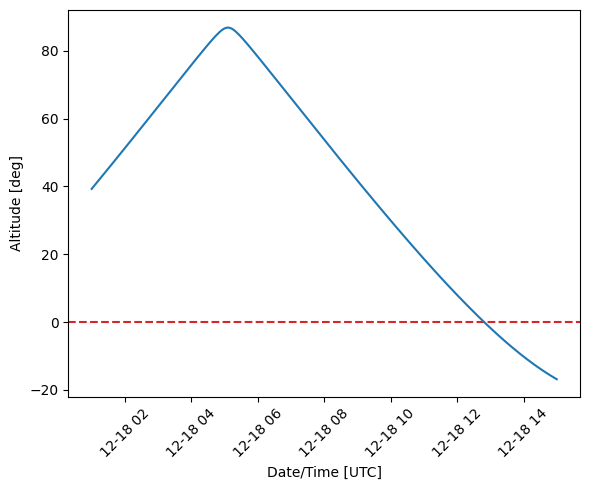

In [31]:
plt.figure(figsize=(6, 5))
plt.plot(time_grid.datetime, oc_altaz.alt.degree, marker='')
plt.axhline(0, zorder=-10, linestyle='--', color='tab:red')
plt.xlabel('Date/Time [UTC]')
plt.ylabel('Altitude [deg]')
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()

Here we can see that this open cluster reaches a high altitude above the horizon from Kitt Peak, and so it looks like it would be observable from this site. The above curve only shows the altitude trajectory for the first open cluster in our catalog, but we would like to compute the equivalent for *all* of the open clusters in the catalog. To do this, we have to make use of a concept that is used heavily in Numpy: [array broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html). We have 474 open clusters and we want to evaluate the `AltAz` coordinates of these clusters at 256 different times.

In [32]:
len(open_cluster_c), len(altaz.obstime)

(474, 256)

We therefore want to produce a two-dimensional coordinate object that is indexed along one axis by the open cluster index, and along other axis by the time index. The `astropy.coordinates` transformation machinery supports array-like broadcasting, so we can do this by creating new, unmatched, length-1 axes on both the open clusters `SkyCoord` object and the `AltAz` frame using `numpy.newaxis` ([doc](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis)):

In [33]:
open_cluster_altaz = open_cluster_c[:, np.newaxis].transform_to(altaz[np.newaxis])

Let's now over-plot the trajectories for the first 10 open clusters in the catalog:

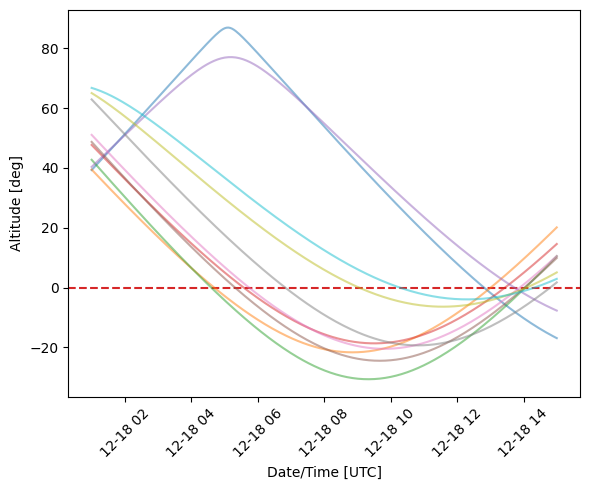

In [34]:
plt.figure(figsize=(6, 5))
plt.plot(time_grid.datetime, 
         open_cluster_altaz[:10].alt.degree.T, 
         marker='', alpha=0.5)
plt.axhline(0, zorder=-10, linestyle='--', color='tab:red')
plt.xlabel('Date/Time [UTC]')
plt.ylabel('Altitude [deg]')
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()

From this, we can see that only two of the clusters in this batch seem to be easily observable.

## Potential Caveats

Transformations between some reference frames require knowing more information about a source. For example, the transformation from ICRS to Galactic coordinates (as demonstrated above) amounts to a 3D rotation, but no change of origin. This transformation is therefore supported for any spherical position (with or without distance information). However, some transformations include a change of origin, and therefore require that the source data (i.e., the `SkyCoord` object) has defined distance information. For example, for a `SkyCoord` with only sky position, we can transform from the ICRS to the FK5 coordinate system:

In [35]:
icrs_c = coord.SkyCoord(150.4*u.deg, -11*u.deg)
icrs_c.transform_to(coord.FK5())

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (150.40000705, -11.00000493)>

However, we would **NOT** be able to transform this position to the `Galactocentric` frame ([docs](https://docs.astropy.org/en/stable/coordinates/galactocentric.html)), because this transformation involves a shift of origin from the solar system barycenter to the Galactic center:

In [36]:
# This cell will raise an exception and will not work (you will see a `ConvertError` exception) - this is expected!

icrs_c.transform_to(coord.Galactocentric())

ConvertError: Transforming to/from a Galactocentric frame requires a 3D coordinate, e.g. (angle, angle, distance) or (x, y, z).

In this tutorial, we have introduced the key concepts that underly the `astropy.coordinates` framework: coordinate component formats, representations, and frames. We demonstrated how to change the representation of a `SkyCoord` object (e.g., Cartesian to Cylindrical). We then introduce the concept of coordinate frames and frame transformations.

## Exercises

Przybylski’s star or HD101065 is in the southern constellation of Centaurus with a right ascension of 174.4040348 degrees and a declination of -46.70953633 degrees. Create a `SkyCoord` object of its sky position. 

If the distance to Przybylski’s star is 108.4 pc, retrieve a 3D Cartesian representation. (Hint: we did this earlier in the tutorial and it may help to create a new 3D `SkyCoord` object.) 

Imagine it is May 2018, and you would like to take an observation of HD 101065 from Greenwich Royal Observatory. Use astropy.coordinates to figure out if you can observe the star that month (hint: use the `EarthLocation` class). You can use any time and date of that month for your timeframe.